In [2]:
import numpy as np 
import cv2 
import time

import tkinter as tk
from tkinter import filedialog

#select video 
root = tk.Tk()
root.withdraw()
root.update()
vid = filedialog.askopenfilename()
root.destroy()

In [11]:
#draw grid and have vectors point in direction of movement 
def draw_flow(img, flow, step=16):
    
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1,2,2)
    lines = np.int32(lines) #+0.5
    
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(img_bgr, lines, 0, (0, 255, 0))
    
    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img_bgr, (x1, y1), 1, (0, 255, 0), -1)
        
    return img_bgr


def draw_hsv(flow):
    
    h, w = flow.shape[:2]
    fx, fy = flow[...,0], flow[...,1]
    
    v = np.sqrt(fx*fx+fy*fy)
    ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])[1]
    ang = np.degrees(ang)

    #mask for movement directed below horizontal -- https://i.stack.imgur.com/PSTeL.png
    mask = (ang >= 0) & (ang <= 180)
    
    #below has which values correspond to which hsv colors on the 0-180 spectrum. -- https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv
    ang[mask] = 90 #down is cyan
    ang[~mask] = 0 #up is red
    
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[..., 0] = ang 
    hsv[..., 1] = 255
    hsv[..., 2] = np.minimum(v*16, 255)  #multiplier for color strengh

    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return bgr

# def plot_meanFlow(frame_counter, flow):
#     plot = np.ones((100, 512, 3), dtype=np.uint8) * 255
    


#frame_counter = 0

flows = []

#Start video capture

cap = cv2.VideoCapture(vid)

ret, prev = cap.read()
prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

while True:
    
    ret, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    s = time.time()

    #a,b,c,pyr_scale, pyr_level,winSize:high=better fast motion detection, iterations@pyr_level, 
    flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 10, 5, 5, 1.1, 0) 
    prevgray = gray
    
    cv2.imshow('flow', draw_flow(gray, flow))
    
    
    
        
    e = time.time()
    
    fps = 1/(e-s)
    
    #print(f"{fps:.2f} FPS")
    
    
    key = cv2.waitKey(5)
    if key == ord('q'):
        break
        

cap.release()
cv2.destroyAllWindows()
    

In [3]:
cap = cv2.VideoCapture(vid)
fps = cap.get(cv2.CAP_PROP_FPS)
print(fps)

mags = []
flow_means = []

ret, prev = cap.read()
prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

while ret:
    ret, img = cap.read()
    
    if not ret: 
        break
        
    s = time.time()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #a,b,c,pyr_scale, pyr_level,winSize:high=better fast motion detection, iterations@pyr_level, 
    flow = cv2.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 10, 5, 5, 1.1, 0)
    prevgray = gray
    mag = np.sqrt(flow[..., 0] ** 2 + flow[..., 1] ** 2)

    mags.append(mag)
    
    if len(mags) == 100:
        mag_total = np.sum(mags)
        flow_mean = np.mean(mag_total)
        flow_means.append(flow_mean)
        
        mags = []
    
    e = time.time()
    t = e-s
    print(f"{t:.2f} seconds/cycle")
    
cap.release()


100.0435547897477
0.05 seconds/cycle
0.05 seconds/cycle
0.04 seconds/cycle
0.04 seconds/cycle
0.07 seconds/cycle
0.07 seconds/cycle
0.05 seconds/cycle
0.04 seconds/cycle
0.05 seconds/cycle
0.05 seconds/cycle
0.07 seconds/cycle
0.04 seconds/cycle
0.05 seconds/cycle
0.06 seconds/cycle
0.07 seconds/cycle
0.07 seconds/cycle
0.07 seconds/cycle
0.04 seconds/cycle
0.07 seconds/cycle
0.07 seconds/cycle
0.07 seconds/cycle
0.06 seconds/cycle
0.06 seconds/cycle
0.07 seconds/cycle
0.06 seconds/cycle
0.04 seconds/cycle
0.05 seconds/cycle
0.04 seconds/cycle
0.08 seconds/cycle
0.06 seconds/cycle
0.05 seconds/cycle
0.04 seconds/cycle
0.05 seconds/cycle
0.07 seconds/cycle
0.04 seconds/cycle
0.06 seconds/cycle
0.04 seconds/cycle
0.05 seconds/cycle
0.09 seconds/cycle
0.07 seconds/cycle
0.04 seconds/cycle
0.04 seconds/cycle
0.05 seconds/cycle
0.05 seconds/cycle
0.07 seconds/cycle
0.06 seconds/cycle
0.06 seconds/cycle
0.06 seconds/cycle
0.04 seconds/cycle
0.04 seconds/cycle
0.05 seconds/cycle
0.04 seconds/

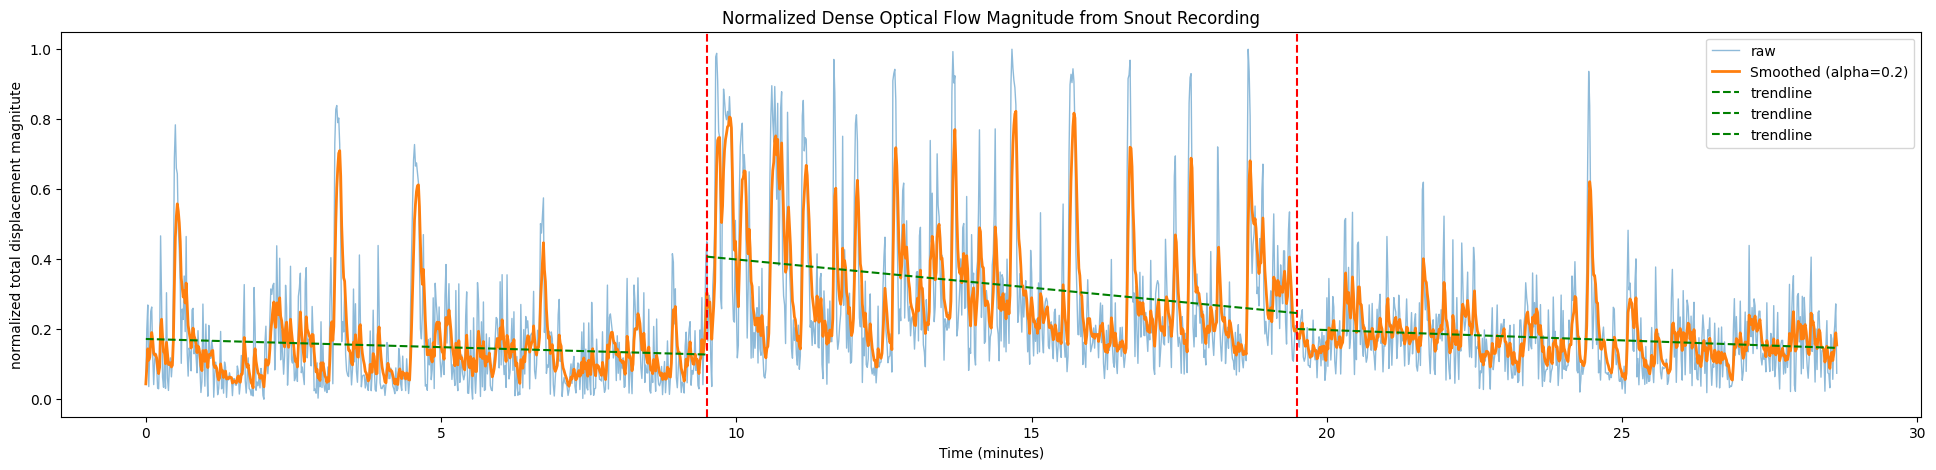

In [48]:
import matplotlib.pyplot as plt
import numpy as np

flow_means = np.array(flow_means)
mi, ma = min(flow_means), max(flow_means)
flow_norm = [(x - mi) / (ma - mi) for x in flow_means]
t = np.arange(0, len(flow_norm))/60

def exp_smooth(ar, alpha=0.2):
    smoothed_data = [ar[0]]  # Start with the first value
    for i in range(1, len(ar)):
        smoothed_value = alpha * ar[i] + (1 - alpha) * smoothed_data[-1]
        smoothed_data.append(smoothed_value)
    return smoothed_data

flow_smooth = exp_smooth(flow_norm, alpha=0.3)
#flow_smooth = exp_smooth(flow_smooth, alpha=0.05)
#flow_smooth = exp_smooth(flow_smooth, alpha=0.05)


#PLOT RAW, SMOOTH, and VERTICAL LINES
fig, ax = plt.subplots(figsize=(24, 5))  # Adjust the figure size as needed

ax.plot(t, flow_norm, label='raw', linewidth=1, alpha=0.5)
ax.plot(t, flow_smooth, label=f'Smoothed (alpha={0.2})', linewidth=2)

x_positions = [9.5, 19.5]  
for x_pos in x_positions:
    plt.axvline(x=x_pos, color='red', linestyle='--')
    
#PLOT TRENDLINES OVER BASELINE & STIMULUS SECTIONS
t_ranges = [(0, 9.5), (9.5, 19.5), (19.5, max(t))]
trend_x, trend_y = [], []
flow_norm = np.array(flow_norm)
for t_range in t_ranges:
    start, end  = t_range
    mask = (t >= start) & (t <= end)
    
    x, y = t[mask], flow_norm[mask]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    
    ax.plot(x, p(x), "g--", label='trendline')
    
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('normalized total displacement magnitute')
ax.set_title('Normalized Dense Optical Flow Magnitude from Snout Recording')
ax.legend()

plt.show()


#plt.savefig(r"C:\Users\emricklab\Desktop\optical_flow_plot.png", dpi=300, bbox_inches='tight')


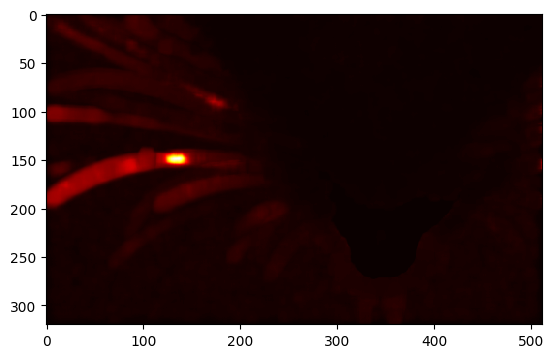

In [40]:
import matplotlib.pyplot as plt

mags = []

for f in flows:
    mag = np.sqrt(f[..., 0] ** 2 + f[..., 1] ** 2)
    mags.append(mag)

frame = 0

offset = 40

sum_energy = np.sum(mags[frame:frame+offset], axis=0)

plt.imshow(sum_energy, cmap='hot', interpolation='nearest')



In [92]:
cap = cv2.VideoCapture(vid)

ret, fr1 = cap.read()
fr1_g = cv2.cvtColor(fr1, cv2.COLOR_BGR2GRAY)

ret, fr2 = cap.read()
fr2_g = cv2.cvtColor(fr2, cv2.COLOR_BGR2GRAY)

cap.release()

s = time.time()
flow = cv2.calcOpticalFlowFarneback(fr1_g, fr2_g, None, 0.5, 3, 15, 3, 5, 1.2, 0)
e = time.time()

#mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

print(str(1/(e-s)) + " Hz")

13.878084208784847 Hz
